In [743]:
import fitsio
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt

from base64 import b64encode
import mechanize

%matplotlib inline

# I'm using Pandas (based on numpy), which is a very useful tool for
# handling tables and data.
# I'll properly put them into classes or more organized later

In [744]:
#12GB file, be carefull
file_name = 'spAll-v5_10_0.fits'


#The resolution of the map
NSide = 2**5


fits = fitsio.FITS(file_name) 
# to show all names in file
#fits[1]

# Columns we are interested on
cols = ['RA','DEC','THING_ID','MJD','PLATE','FIBERID','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1', 'ZWARNING']

In [748]:
%%time

# Reading columns
#http://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
d = {col: fits[1][col].read().byteswap().newbyteorder() for col in cols}

CPU times: user 21.2 s, sys: 1min 2s, total: 1min 24s
Wall time: 3min 15s


In [749]:
df = pd.DataFrame(d)
print 'number of rows =', len(df)
df.head()

number of rows = 3008000


,BOSS_TARGET1,DEC,EBOSS_TARGET0,EBOSS_TARGET1,FIBERID,MJD,PLATE,RA,THING_ID,ZWARNING
0,0,26.188042,0,2,1,57346,10000,30.012094,339167825,646
1,0,26.582945,0,1024,2,57346,10000,31.282286,342410358,0
2,0,26.608501,0,2,3,57346,10000,31.279594,342410449,4
3,0,26.682522,0,2048,4,57346,10000,31.237546,342675982,0
4,0,26.866054,0,2,5,57346,10000,31.394521,344112497,4


## Computing pixels

In [1076]:
'''map celestial coordinates to angular'''
phi_rad   = lambda ra : ra*np.pi/180.
theta_rad = lambda dec: (90.0 - dec)*np.pi/180.

df['PIX'] = hp.ang2pix(NSide, theta_rad(df['DEC']), phi_rad(df['RA']))

# Number of unique pixels
len(df['PIX'].unique())

3369

In [1077]:
df.head()

,BOSS_TARGET1,DEC,EBOSS_TARGET0,EBOSS_TARGET1,FIBERID,MJD,PLATE,RA,THING_ID,ZWARNING,PIX
0,0,26.188042,0,2,1,57346,10000,30.012094,339167825,646,3403
1,0,26.582945,0,1024,2,57346,10000,31.282286,342410358,0,3403
2,0,26.608501,0,2,3,57346,10000,31.279594,342410449,4,3403
3,0,26.682522,0,2048,4,57346,10000,31.237546,342675982,0,3403
4,0,26.866054,0,2,5,57346,10000,31.394521,344112497,4,3275


## Searching for quasars

In [753]:
bit_boss = [10,11,12,13,14,15,16,17,18,19,40,41,42,43,44]
bit_eboss = [10,11,12,13,14,15,16,17,18]

def is_quasar(dataset, mask_bit):
    is_qso  = lambda b: ((df[dataset] & 2**b) > 0)
    all_qso = map(is_qso, mask_bit)
    return reduce(lambda x, y: x |  y , all_qso)

In [754]:
print 'total qso in BOSS_TARGET1 =  ', is_quasar('BOSS_TARGET1', bit_boss).sum()
print 'total qso in EBOSS_TARGET0 = ', is_quasar('EBOSS_TARGET0', bit_eboss).sum()
print 'total qso in EBOSS_TARGET1 = ', is_quasar('EBOSS_TARGET1', bit_eboss).sum() 

total qso in BOSS_TARGET1 =   466098
total qso in EBOSS_TARGET0 =  54108
total qso in EBOSS_TARGET1 =  201742


In [755]:
#Filter only quasars

only_qso = df[ is_quasar('BOSS_TARGET1', bit_boss)   |
                 is_quasar('EBOSS_TARGET0', bit_eboss) | 
                 is_quasar('EBOSS_TARGET1', bit_eboss)]
boss_qso = df[ is_quasar('BOSS_TARGET1', bit_boss)]

print 'all_qsos=', len(only_qso) 
print 'boss_qsos=', len(boss_qso) 

qsos= 721948
boss_qsos= 466098


## indexing and sorting by index


In [1081]:
#Eliminate quasars that have THING_ID == -1

all_qso = only_qso[only_qso['THING_ID'] != -1].set_index(['PIX','THING_ID'], drop=False).drop('PIX', 1).sort_index()
all_qso.head()

BOSS_TARGET1        DEC  EBOSS_TARGET0  EBOSS_TARGET1  \
PIX THING_ID                                                            
391 552894319  2199023796224  68.381197              0              0   
    552921545  2199023796224  68.418125              0              0   
392 552514273  3298535424000  68.011275              0              0   
    552514407  3298535424000  68.070896              0              0   
    552709867  2199023796224  68.289380              0              0   

               FIBERID    MJD  PLATE          RA   THING_ID  ZWARNING  
PIX THING_ID                                                           
391 552894319      622  56667   7115  175.258222  552894319         0  
    552921545      624  56667   7115  175.582630  552921545         0  
392 552514273      932  56748   6966  185.714425  552514273         0  
    552514407      886  56748   6966  185.578268  552514407         0  
    552709867      880  56748   6966  185.466450  552709867         0

In [1082]:
print (len(all_qso))

721810


### Select  a certain pixel info

In [759]:
#only the first rows of pixel 393
all_qso.query('PIX == 450 | PIX == 796').head()

BOSS_TARGET1        DEC  EBOSS_TARGET0  EBOSS_TARGET1  \
PIX THING_ID                                                            
450 550116719  2199023255552  66.581635              0              0   
    550164118  2199023796224  66.543038              0              0   
    550164118  2199023796224  66.543038              0              0   
    550452152  2199023779840  66.701205              0              0   
    550452390  3298535424000  66.775943              0              0   

               FIBERID    MJD  PLATE          RA   THING_ID  ZWARNING  
PIX THING_ID                                                           
450 550116719      914  56720   6975  185.252205  550116719         0  
    550164118       86  56748   6966  185.340753  550164118         0  
    550164118      493  56720   7120  185.340753  550164118         0  
    550452152      976  56720   6975  185.282387  550452152         0  
    550452390       92  56748   6966  185.511519  550452390         0

In [760]:
print '# of THING_IDs within this pixel =', len(all_qso.loc[392].index)
print '# of unique THING_IDs within this pixel =', len(all_qso.loc[392].index.unique())

# of THING_IDs within this pixel = 14
# of unique THING_IDs within this pixel = 14


In [762]:
ss = all_qso.query('PIX == 450').groupby('THING_ID').size()
ss[ss>3].empty 

True

In [763]:
len(all_qso)- len(all_qso['THING_ID'].unique())

68335

In [765]:
pix_values = all_qso.index.values

set_pix = set(pix_values)
list_pix= list(set_pix)

In [766]:
def pix_with_uniqueid(pix_id, max_rep):
    rep_thing_id = all_qso.query('PIX == {}'.format(pix_id)).groupby('THING_ID').size()
    if not rep_thing_id[rep_thing_id> max_rep].empty:
        print rep_thing_id[rep_thing_id> max_rep]
    

In [767]:
for i in list_pix[:200]:
    pix_with_uniqueid(i, 4)

THING_ID
341840093    5
dtype: int64
THING_ID
493044557    5
493044566    5
dtype: int64
THING_ID
492814652    5
dtype: int64
THING_ID
103525683    14
103525770    16
103526510    14
106363307    16
106364494    16
106365271    14
106366014    14
106367792    14
106368778    16
106369646    17
106370968    15
106371135    16
110624111    15
110626380    14
110626688    14
110627392    14
110627658    16
110628288    14
110628681    17
110629518    14
110629784    14
110630924    15
110630953    14
110631121    14
110632201    17
110633310    16
116045026    17
117500366    14
117587824    17
117587864    14
117727485    14
117755110    17
117770491    14
117779618    16
117793096    14
117805119    14
117819099    14
117840082    14
122364168    14
122648904    14
122667423    14
122667772    14
122668008    15
122686196    15
122714605    17
122784266    14
122784797    14
124737036     5
dtype: int64
THING_ID
461347713    5
464694423    5
dtype: int64
THING_ID
489567549    5
dtype: i

In [916]:

def get_file(plate, name_of_file):
    url = 'https://data.sdss.org/sas/ebosswork/eboss/spectro/redux/v5_10_0/spectra/%s/%s'%(plate,name_of_file)
    username = 'sdss'
    password = '2.5-meters'

    # I have had to add a carriage return ('%s:%s\n'), but
    # you may not have to.
    b64login = b64encode('%s:%s' % (username, password))

    br = mechanize.Browser()
    br.set_handle_robots(False)
    # # I needed to change to Mozilla for mine, but most do not
    # br.addheaders= [('User-agent', 'Mozilla/5.0')]

    br.addheaders.append( 
      ('Authorization', 'Basic %s' % b64login )
    )

    br.open(url)
    r = br.response()
    data = r.read()

    with open('%s'%(name_of_file),'wb') as output:
          output.write(data)

## Quasars with same THING_ID

In [1058]:
thing_id = 106369646
all_qso.query('THING_ID == %s'%(thing_id))

BOSS_TARGET1      DEC  EBOSS_TARGET0  EBOSS_TARGET1  FIBERID  \
PIX  THING_ID                                                                   
5965 106369646         217088  0.42662              0              0      693   
     106369646         217088  0.42662              0              0      691   
     106369646         217088  0.42662              0              0      685   
     106369646         217088  0.42662              0              0      699   
     106369646         217088  0.42662              0              0      693   
     106369646         217088  0.42662              0              0      713   
     106369646         217088  0.42662              0              0      692   
     106369646         217088  0.42662              0              0      690   
     106369646         217088  0.42662              0              0      712   
     106369646         217088  0.42662              0              0      690   
     106369646         217088  0.42662              0              0      646   
     106369646         217088  0.42662              0              0      692   
     106369646         217088  0.42662              0              0      700   
     106369646         217088  0.42662              0              0      684   
     106369646  2199023259648  0.42662              0              0      988   
     106369646  2199023259648  0.42662              0              0      684   
     106369646              0  0.42662              0           4096      641   

                  MJD  PLATE         RA   THING_ID  ZWARNING  
PIX  THING_ID                                                 
5965 106369646  55179   3615  36.840932  106369646         0  
     106369646  55208   3615  36.840932  106369646         0  
     106369646  55445   3615  36.840932  106369646         0  
     106369646  55856   3615  36.840932  106369646         0  
     106369646  56219   3615  36.840932  106369646         0  
     106369646  56544   3615  36.840932  106369646         0  
     106369646  55181   3647  36.840932  106369646         0  
     106369646  55241   3647  36.840932  106369646         0  
     106369646  55476   3647  36.840932  106369646         0  
     106369646  55827   3647  36.840932  106369646         0  
     106369646  55945   3647  36.840932  106369646         0  
     106369646  56219   3647  36.840932  106369646         0  
     106369646  56568   3647  36.840932  106369646         0  
     106369646  56596   3647  36.840932  106369646         0  
     106369646  55478   4237  36.840932  106369646         0  
     106369646  55455   4238  36.840932  106369646         0  
     106369646  57039   7828  36.840932  106369646         0

In [1059]:
plates = list(all_qso.query('THING_ID == %s'%(thing_id))['PLATE'].values)
mjds = list(all_qso.query('THING_ID == %s'%(thing_id))['MJD'].values)
fiberids = list(all_qso.query('THING_ID == %s'%(thing_id))['FIBERID'].values)

In [1060]:
files = ['spec-%s-%s-%s.fits'%(plate,mjd,str(fiberid).zfill(4)) for plate,mjd,fiberid in zip(plates,mjds,fiberids)]
plate_n = ['%s'%(plate) for plate in plates]
print files, plate_n

['spec-3615-55179-0693.fits', 'spec-3615-55208-0691.fits', 'spec-3615-55445-0685.fits', 'spec-3615-55856-0699.fits', 'spec-3615-56219-0693.fits', 'spec-3615-56544-0713.fits', 'spec-3647-55181-0692.fits', 'spec-3647-55241-0690.fits', 'spec-3647-55476-0712.fits', 'spec-3647-55827-0690.fits', 'spec-3647-55945-0646.fits', 'spec-3647-56219-0692.fits', 'spec-3647-56568-0700.fits', 'spec-3647-56596-0684.fits', 'spec-4237-55478-0988.fits', 'spec-4238-55455-0684.fits', 'spec-7828-57039-0641.fits'] ['3615', '3615', '3615', '3615', '3615', '3615', '3647', '3647', '3647', '3647', '3647', '3647', '3647', '3647', '4237', '4238', '7828']


In [1061]:
for plate, names in zip(plates, files):
    get_file(plate, names)

In [1062]:
def read_flux(files):
    fits = fitsio.FITS(files)
    cols = ['flux','loglam','ivar','and_mask','or_mask', 'sky', 'wdisp', 'model']
    d = {col: fits[1][col].read().byteswap().newbyteorder() for col in cols}
    df = pd.DataFrame(d)
    return df

In [1063]:
dt_s=[]
for l in files:
        dt_x = read_flux(l).set_index('loglam')
        dt_s.append(dt_x)

In [1064]:
# Masking
mask=[]
for s in dt_s:
    mask.append(s.query('and_mask==0 & or_mask==0').copy())

In [1065]:
mask[1].head()

,and_mask,flux,ivar,model,or_mask,sky,wdisp
loglam,,,,,,,
3.5568,0,3.458888,0.091799,1.213686,0,3.295893,1.327138
3.5569,0,-4.262443,0.107146,1.207373,0,2.727138,1.327356
3.5570,0,-6.218005,0.117155,1.215648,0,2.182058,1.324017
3.5571,0,1.586812,0.111463,1.228762,0,1.973585,1.331405
3.5572,0,-0.065183,0.115181,1.256719,0,2.351248,1.340975


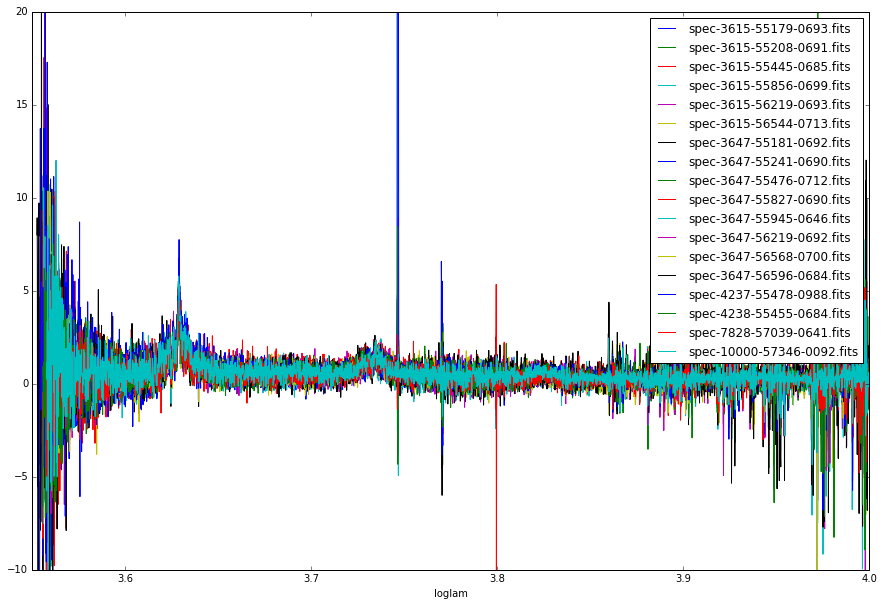

In [1066]:
fig = plt.figure(figsize = (15, 10))
xlimits = [3.55,4]
ylimits = [-10,20]
for i in range(len(files)):
    dt_s[i]['flux'].plot(label=files[i])
dt_s[4]['flux'].plot(xlim=xlimits, ylim=ylimits, label=files_5) 
plt.legend(loc='best')

In [1067]:
#print [len(mask[i]) for i in range(5)]
#for i in range(5):
#    print (mask[i].index.values.min()- mask[i].index.values.max())/len(mask[i])
#for i in range(len(files)):
#    x=dt_s[i].index.values
    #print(len(x))
    #print (x[-1]-x[0])/(len(x)-1)

In [1068]:
#fig = plt.figure(figsize = (15, 10))
#ax= plt.subplot(1,1,1)
##dt_s
#mask[0][['flux','model', 'ivar']].plot(ax=ax)
#mask[1][['flux','model', 'ivar']].plot(ax=ax)

In [1069]:
#fits = fitsio.FITS(files[0])
#coeff0, coeff1 = fits[0].read_header()['COEFF0'], fits[0].read_header()['COEFF1']
#for f in files:
#    fits = fitsio.FITS(f)
#    print fits[0].read_header()['COEFF0'], fits[0].read_header()['COEFF1']

#for i in range(len(files)):
#    x=dt_s[i].index.values
#    print (x[-1]-x[0])/(len(x)-1), len(x)

In [1070]:
for i in range(len(files)):
        dt_s[i]['flux_%s'%(i)] = dt_s[i]['flux']
        dt_s[i]['ivar_%s'%(i)] = dt_s[i]['ivar']

In [1071]:
x =range(len(files))
result = pd.concat([dt_s[i][['flux_%s'%(i),'ivar_%s'%(i)]] for i in x], axis=1)
all_qsos= result.fillna(0).copy()
all_qsos.head()

,flux_0,ivar_0,flux_1,ivar_1,flux_2,ivar_2,flux_3,ivar_3,flux_4,ivar_4,...,flux_12,ivar_12,flux_13,ivar_13,flux_14,ivar_14,flux_15,ivar_15,flux_16,ivar_16
loglam,,,,,,,,,,,,,,,,,,,,,
3.5525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.5526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.5527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.5528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.5529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1072]:
all_qsos['sum_flux_ivar']=0
all_qsos['sum_ivar']=0
for i in x:
    all_qsos['sum_flux_ivar']+= all_qsos['flux_%s'%(i)]*all_qsos['ivar_%s'%(i)]
    all_qsos['sum_ivar']+= all_qsos['ivar_%s'%(i)] 
all_qsos['coadd'] = all_qsos['sum_flux_ivar']/all_qsos['sum_ivar']

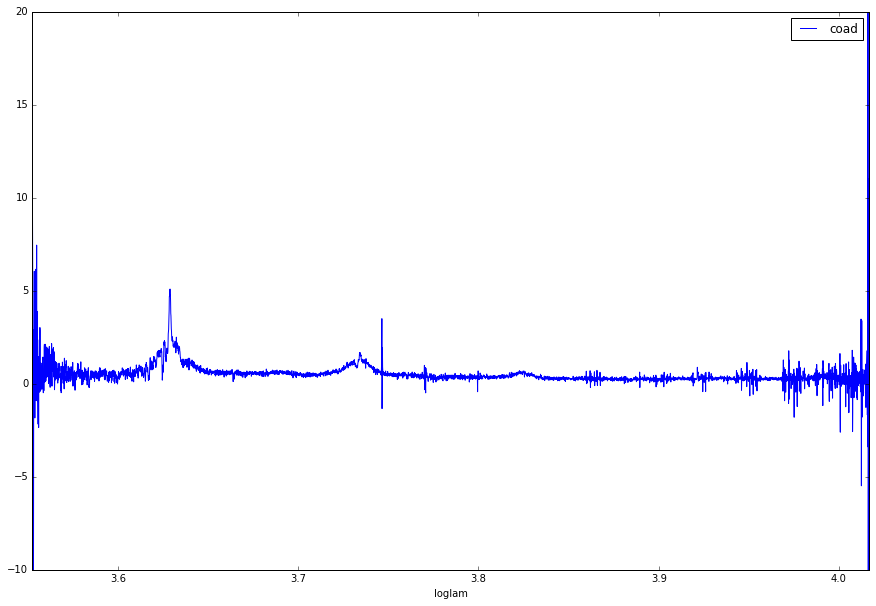

In [1073]:
fig = plt.figure(figsize = (15, 10))
ax= plt.subplot(1,1,1)
all_qsos['coadd'].plot(ax=ax, label='coad')
#for i in x:
#    all_qsos['flux_%s'%(i)].plot(ax=ax)
plt.ylim([-10,20])
plt.legend(loc='best')

In [1074]:
all_qsos = all_qsos.fillna(0).copy()
all_qsos['coadd'].values

array([  8.00602631,   8.92329408,   6.29712816, ...,  -1.62233003,
        -7.45756262, -21.88217937])

In [1075]:
for i in x:
    chi_squared = np.sum((all_qsos['coadd'].values - all_qsos['flux_%s'%(i)].values)**2*all_qsos['ivar_%s'%(i)].values)
    print  'chi-sq=',chi_squared/len(all_qsos.values), '\t', files[i]

chi-sq= 1.18316693261 	spec-3615-55179-0693.fits
chi-sq= 0.814630036411 	spec-3615-55208-0691.fits
chi-sq= 0.950363933276 	spec-3615-55445-0685.fits
chi-sq= 1.02254375672 	spec-3615-55856-0699.fits
chi-sq= 0.862993206424 	spec-3615-56219-0693.fits
chi-sq= 0.974970030558 	spec-3615-56544-0713.fits
chi-sq= 1.0354952373 	spec-3647-55181-0692.fits
chi-sq= 1.39189271561 	spec-3647-55241-0690.fits
chi-sq= 0.926219350812 	spec-3647-55476-0712.fits
chi-sq= 0.935085283558 	spec-3647-55827-0690.fits
chi-sq= 0.979185019436 	spec-3647-55945-0646.fits
chi-sq= 0.864700491685 	spec-3647-56219-0692.fits
chi-sq= 1.0134173737 	spec-3647-56568-0700.fits
chi-sq= 0.948529755146 	spec-3647-56596-0684.fits
chi-sq= 1.16203634253 	spec-4237-55478-0988.fits
chi-sq= 0.854323898489 	spec-4238-55455-0684.fits
chi-sq= 0.979416702791 	spec-7828-57039-0641.fits
